In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.4 MB/s eta 0:00:00


In [3]:
vggish = torch.hub.load('harritaylor/torchvggish', 'vggish')
vggish = vggish.features.eval()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/harritaylor/torchvggish/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth
100%|██████████| 275M/275M [00:01<00:00, 148MB/s]
Downloading: "https://github.com/ha

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [16]:
content_layers_default = ['conv_1']
style_layers_default = ['conv_1', 'conv_2']

def get_style_model_and_losses(vggish,
                               style_audio, content_audio,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    content_losses = []
    style_losses = []
    model = nn.Sequential()

    i = 0
    for layer in vggish.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_audio).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_audio).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break
    #print(i)
    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [6]:
def get_input_optimizer(input_audio):
    optimizer = optim.LBFGS([input_audio])
    return optimizer

In [7]:
def run_audio_style_tranfer(model, content_audio, style_audio, input_audio, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(model,style_audio,content_audio)

    input_audio.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_audio)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

      def closure():
        # with torch.no_grad():
        #     input_audio.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_audio)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 10 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score

      optimizer.step(closure)

    # with torch.no_grad():
    #     input_img.clamp_(0, 1)

    return input_audio

In [8]:
!git clone https://github.com/harritaylor/torchvggish.git

Cloning into 'torchvggish'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 209 (delta 29), reused 24 (delta 24), pack-reused 172
Receiving objects: 100% (209/209), 328.85 KiB | 2.99 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [9]:
from torchvggish.torchvggish.vggish_input import waveform_to_examples
import librosa

In [10]:
x, fs = librosa.load('style.m4a', sr=16000)
style_audio = waveform_to_examples(x, fs)
x1, fs1 = librosa.load('content.m4a', sr=16000)
content_audio = waveform_to_examples(x1, fs1)

<ipython-input-10-7d46623fb397>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  x, fs = librosa.load('style.m4a', sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-10-7d46623fb397>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  x1, fs1 = librosa.load('content.m4a', sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [11]:
#First test: assume style audio length > content audio length

style_audio = style_audio[:content_audio.shape[0],:,:,:]
print("Size of style audio: ", style_audio.shape)
print("Size of content audio: ", content_audio.shape)

Size of style audio:  torch.Size([5, 1, 96, 64])
Size of content audio:  torch.Size([5, 1, 96, 64])


In [17]:
input_audio = torch.randn(content_audio.data.size())
output_audio = run_audio_style_tranfer(vggish, content_audio, style_audio, input_audio, num_steps=50, style_weight=10000000, content_weight=1)

Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 0.014868 Content Loss: 0.014655

run [20]:
Style Loss : 0.002525 Content Loss: 0.006633

run [30]:
Style Loss : 0.000802 Content Loss: 0.003664

run [40]:
Style Loss : 0.000682 Content Loss: 0.002806

run [50]:
Style Loss : 0.000640 Content Loss: 0.002522

run [60]:
Style Loss : 0.000621 Content Loss: 0.002450



In [18]:
import numpy as np

num_exs,_,frames,bands = output_audio.shape
output_test = np.zeros((64, 570))
output_test[:,:480] = torch.reshape(output_audio, (num_exs*frames, bands)).detach().numpy().T


audio_sample_rate = 16000
window_length_secs = 0.025
hop_length_secs = 0.01
window_length_samples = int(round(audio_sample_rate * window_length_secs))
hop_length_samples = int(round(audio_sample_rate * hop_length_secs))
fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))

a_o = librosa.feature.inverse.mel_to_stft(output_test, sr=audio_sample_rate, power=1, n_fft=fft_length)
a_o = librosa.griffinlim(a_o, n_fft=fft_length, win_length=window_length_samples, hop_length=hop_length_samples)

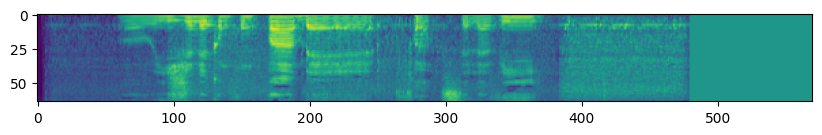

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(output_test)

In [20]:
from IPython.display import Audio, display
import soundfile as sf
OUTPUT_FILENAME = 'out.wav'

sf.write(OUTPUT_FILENAME, a_o, audio_sample_rate, 'PCM_24')
display(Audio("out.wav"))